# Practical 1: Kinetic mass transfer 

Consider the volatile hydrocarbon toluene with the Henry’s partitioning coefficient between air and water of 1.5x10-3[mol · m−3· Pa−1].
The compound is introduced at time zero into the gaseous phase at a concentration, ${c^{t=0}}_g$, of a 2 L reactor with equal volume parts of headspace (air / gas) and water. When dissolved in water the compound undergoes first-order decay with a rate constant, k, of 1 [day-1].
Assume that the initial concentration in the water is zero. The area of the interface, Ag↔w, is 0.01 [m2]. The gas exchange velocity, vg↔w, is 1 [mm min-1].

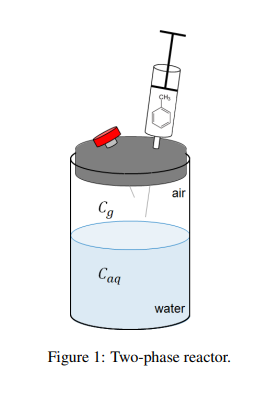

In [1]:
from IPython.display import Image
Image(filename='figures/practical_1_1.png')

### 1. Write the problem at hand in matrix-vector notation

with explicit statement of the coefficient matrix A. Make sure to be consistent in how you define H

#### Part a. Defining H:

As the problem states we need to be consistent with our H definition as seen in class. For this we will use the gas law to convert the given Henry's law coefficient defined in terms of gas partial pressures to dimensionless H coefficient:

In [2]:
import sympy

The gas law:

In [3]:
H = sympy.symbols('H', real = True, positive = True) # dimensionless coefficient
K_h = sympy.symbols('K_h', real = True, positive = True) # partial pressures coefficient
R = sympy.symbols('R', real = True, positive = True) # dimensionless gas law
T = sympy.symbols('T', real = True, positive = True) # temperature
p = sympy.symbols('p', real = True, positive = True) # partial pressure
c_g = sympy.symbols('c_g', real = True, positive = True) # concentration in gas
c_l = sympy.symbols('c_l', real = True, positive = True) # concentration in liquid

If we use the ideal gas law:

In [4]:
p = c_g*R*T # gas law

In [5]:
p

R*T*c_g

And mix with the Henry's law:

In [6]:
K_h = c_l/p

In [7]:
K_h

c_l/(R*T*c_g)

Now we need an expression linking Kh with H. 
H in the derivation of the mass transfer problem is defined as such:


In [8]:
H = c_g/c_l

In [9]:
H

c_g/c_l

So I will rewrite the Henry's Law to get an expression for $H$:

In [10]:
expr = K_h*H
K_h = sympy.symbols('K_h', real = True, positive = True) # partial pressures coefficient
H = expr/K_h

In [11]:
H

1/(K_h*R*T)

Now we can get the function to evaluate H and calculate its value:

In [12]:
H_function = sympy.lambdify([K_h,R,T], H)

In [13]:
Kh = 1.5e-3
R = 8.31446
T = 273.15+25

In [14]:
Henry = H_function(Kh,R,T)

In [15]:
Henry

0.2689303883179048

#### Part b. Building the derivatives in matrix notation:

We begin by writing the derivatives:

In [16]:
cw,cg,t,Vw,Vg,l,H,k = sympy.symbols('c_w c_g t V_w V_g lambda H k', real = 'True', positive = 'True')

In [17]:
dcgdt = (Vw/Vg)*l*(cw-cg/H)

In [18]:
dcwdt = l*(cg/H-cw)-k*cw

$\frac{\partial c_w}{\partial t}$

In [19]:
dcgdt

V_w*lambda*(c_w - c_g/H)/V_g

$\frac{\partial c_g}{\partial t}$

In [20]:
dcwdt

-c_w*k + lambda*(-c_w + c_g/H)

Now we must factor our the concentration terms and build our matrix:

In [21]:
A = sympy.linear_eq_to_matrix([dcgdt,dcwdt], [cg,cw])[0]

In [22]:
A

Matrix([
[-V_w*lambda/(H*V_g), V_w*lambda/V_g],
[           lambda/H,    -k - lambda]])

In [23]:
c = sympy.Matrix([cg,cw])

In [24]:
c

Matrix([
[c_g],
[c_w]])

### 2. Calculate the Analytical solution:
Use the matrix exponential function (expm) in Matlab to calculate the analytical solution for an initial concentration in the gas phase, ${c^{t=0}}_g$ of 10 [mmol L-1]. Compare the case
without decay in the aqueous phase and the case with decay

In [25]:
import numpy as np
import scipy

In [27]:

A_v = 0.01 #[m2]
v = 1*1e-3*60*24 #[mm/min]


Substituting the variables with the given problem variables:

In [28]:
A_m = sympy.lambdify([Vw,Vg,l,k,H],A, 'numpy')

In [29]:
A = A_m(1e-3,1e-3,A_v*v/1e-3,1,H_function(Kh,8.31446,273.15+25))

In [30]:
A*t

array([[-53.5454549784*t, 14.4*t],
       [53.5454549784*t, -15.4*t]], dtype=object)

In [45]:
t = 0
cg,cw = np.dot(scipy.linalg.expm(A*t),np.array([10*1e-3,0]))

In [46]:
cg,cw

(0.01, 0.0)

In [47]:
dt = 0.01
t_range = np.arange(0,8+dt,dt)
cg_a = np.zeros(t_range.shape)
cw_a =np.zeros(t_range.shape)
i = 0
cg0 = cg
cw0 = cw
for t in t_range:
    cg,cw = np.dot(scipy.linalg.expm(A*t),np.array([cg0,cw0]))
    cg_a[i] = cg
    cw_a[i] = cw
    i+=1

In [48]:
import matplotlib.pyplot as plt

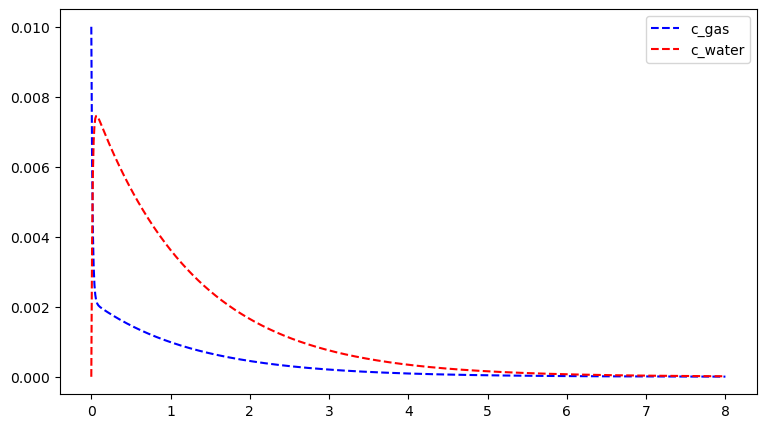

In [49]:
fig, ax = plt.subplots(figsize = (9,5))
ax.plot(t_range,cg_a,'--b', label = 'c_gas')
ax.plot(t_range,cw_a,'--r', label = 'c_water')
ax.legend()

Comparing the numerical solution with the analytical solution:

In [50]:
cw,cg = sympy.symbols('c_w c_g', real = 'True', positive = 'True')

In [51]:
dcgdt = (Vw/Vg)*l*(cw-cg/H)

In [52]:
dcwdt = l*(cg/H-cw)-k*cw

In [53]:
A = sympy.linear_eq_to_matrix([dcgdt,dcwdt], [cg,cw])[0]

In [54]:
A_m = sympy.lambdify([Vw,Vg,l,k,H],A, 'numpy')

In [56]:
def f(t, y, Vw,Vg,l,k,H):
    dydt = np.dot(A_m(Vw,Vg,l,k,H),y)
    return dydt

sol = scipy.integrate.solve_ivp(f, (t_range[0],t_range[-1]),np.array([cg0,cw0]),method = 'RK45',t_eval = t_range, args = (1e-3,1e-3,A_v*v/1e-3,1,Henry))

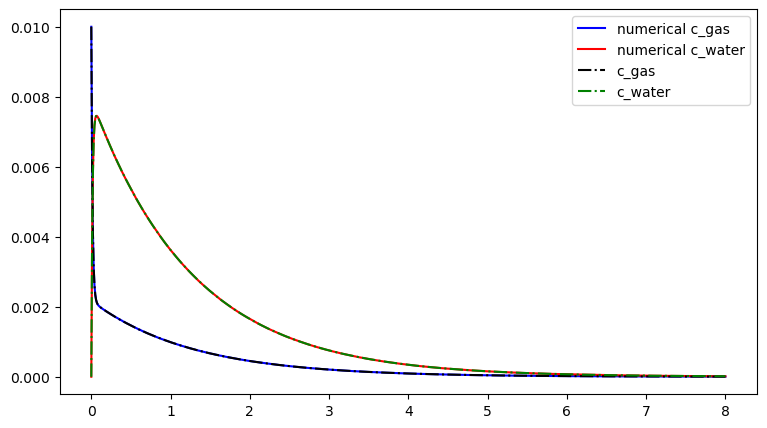

In [60]:
fig, ax = plt.subplots(figsize = (9,5))
ax.plot(t_range,sol.y[0,:], '-b', label = 'numerical c_gas')
ax.plot(t_range,sol.y[1,:], '-r', label = 'numerical c_water')
ax.plot(t_range,cg_a,'-.k', label = 'c_gas')
ax.plot(t_range,cw_a,'-.g', label = 'c_water')
ax.legend()

The analytical solution and the numerical solution are essencialy the same for this exercise.

#### 2.b. Removing the decaying ratio:

In [293]:
cw,cg,t,Vw,Vg,l,H,k = sympy.symbols('c_w c_g t V_w V_g lambda H k', real = 'True', positive = 'True')

In [294]:
dcgdt = (Vw/Vg)*l*(cw-cg/H)

In [295]:
dcwdt = l*(cg/H-cw)

In [296]:
A = sympy.linear_eq_to_matrix([dcgdt,dcwdt], [cg,cw])[0]

In [297]:
A

Matrix([
[-V_w*lambda/(H*V_g), V_w*lambda/V_g],
[           lambda/H,        -lambda]])

In [298]:
A_m = sympy.lambdify([Vw,Vg,l,H],A, 'numpy')

In [299]:
A = A_m(1e-3,1e-3,A_v*v/1e-3,H_function(Kh,8.31446,273.15+25))

In [300]:
A

array([[-53.54545498,  14.4       ],
       [ 53.54545498, -14.4       ]])

In [307]:
dt = 0.01
t_range = np.arange(0,0.3+dt,dt)
cg_a = np.zeros(t_range.shape)
cw_a =np.zeros(t_range.shape)
i = 0
for t in t_range:
    cg,cw = np.dot(scipy.linalg.expm(A*t),np.array([1.5e-3,0]))
    cg_a[i] = cg
    cw_a[i] = cw
    i+=1

In [305]:
import matplotlib.pyplot as plt

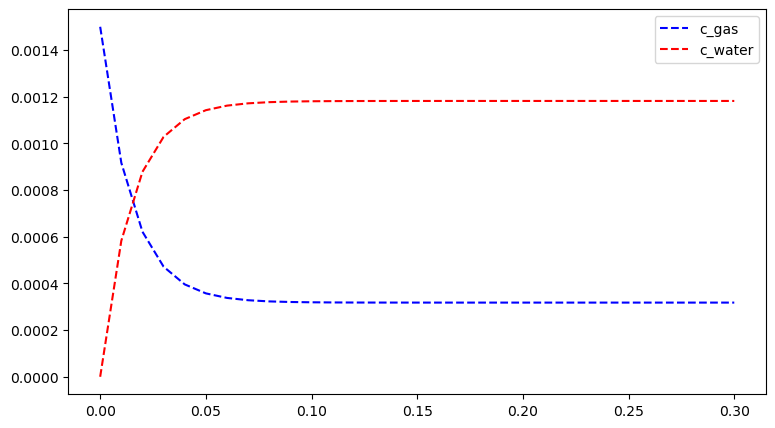

In [308]:
fig, ax = plt.subplots(figsize = (9,5))
ax.plot(t_range,cg_a,'--b', label = 'c_gas')
ax.plot(t_range,cw_a,'--r', label = 'c_water')
ax.legend()

Solutions reach equilibrium quickly